## SVM Implementation on scaled reduced dataset with PCA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

Read Train Data

In [4]:
columns_PCA = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
           'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18']

In [5]:
X_train= pd.read_csv('../../DimensionalityReductionData/X_train_PCA.csv', names=columns_PCA)
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.230656,-0.540199,0.275241,0.348734,0.442168,-0.244893,-0.305579,-0.388014,0.483440,-0.050057,0.114171,0.037729,-0.133432,0.084029,0.211571,-0.000299,0.276030,0.133585
1,-0.578532,-0.273813,-0.207024,0.202237,0.438744,-0.422858,0.108360,-0.469457,0.476055,0.098184,0.022312,0.125669,0.187688,-0.019637,-0.181937,-0.064250,-0.107400,0.057437
2,-0.207271,1.096294,-0.124524,-0.014919,0.302102,0.276747,0.024807,-0.079499,0.016929,0.018033,-0.071089,-0.003510,-0.020689,-0.065503,-0.117356,-0.056667,-0.133169,-0.121348
3,-0.549501,-0.271749,0.166219,0.161220,0.278617,-0.671476,-0.287128,0.591844,-0.668737,-0.173965,-0.421168,-0.101647,-0.332900,-0.157359,0.086729,0.130933,-0.221770,-0.134654
4,-0.605220,-0.210550,-0.406984,0.455269,-0.336895,0.182399,0.298030,0.309622,0.071143,-0.035126,0.191219,-0.142084,0.191455,0.036069,-0.138503,0.001297,-0.030649,0.106555


Read Test Data

In [6]:
X_test = pd.read_csv('../../DimensionalityReductionData/X_test_PCA.csv', names=columns_PCA)
X_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,0.325189,-0.474065,0.148350,0.015025,0.453967,-0.382437,0.009063,0.696200,-0.577426,-0.029937,-0.099144,0.654157,0.475839,0.289828,-0.034359,-0.584359,0.783886,-0.206918
1,-0.553038,-0.060147,0.246432,-0.094217,-0.152499,-0.133879,0.046601,-0.127948,-0.063073,-0.262155,0.036293,-0.084048,-0.114584,0.030450,0.102251,-0.048580,0.100263,0.069443
2,-0.543513,-0.099255,0.273981,-0.140697,-0.202855,-0.145719,-0.165479,-0.040533,-0.045461,-0.230001,0.047889,-0.076919,-0.013481,0.034937,0.047416,-0.038551,0.040234,0.096922
3,0.604992,0.850389,0.205670,0.134501,0.422158,0.448003,-0.124164,-0.002779,0.023872,-0.005055,-0.010426,-0.033946,-0.181834,0.042114,0.137483,0.011521,0.138021,0.009279
4,-0.222045,1.101761,-0.093482,-0.005867,0.283825,0.294311,0.032426,-0.116046,0.009989,-0.017200,-0.072850,-0.009081,-0.097862,-0.067777,-0.070239,-0.058562,-0.076902,-0.149065


Do Train-Test Split to define y_train, y_test (both are raings)
!!!! IMPORTANT use random_state as defined in Dimension Reduction DATA SPLIT!!!!

In [7]:
y_train, y_test = train_test_split(df_scaled['averageRating'], test_size=0.2, random_state=42)

Now everything is defined (X_train, X_test, y_train, y_test)

Save and print metrics

In [8]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [9]:
model = SVC(random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7255163224516988
F1 score: [0.74425822 0.70381021]


## Grid Search CV - 1

In [10]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

model = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   1.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   1.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.6s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   2.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   2.6s
[CV] END ...................C=0.1, gamma=auto, k

In [11]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                              params  mean_test_score
16      {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}         0.723199
28      {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}         0.722782
24     {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}         0.721366
8        {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.720783
26    {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}         0.719450
18     {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}         0.718450
20       {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}         0.718284
12        {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}         0.716201
10      {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}         0.713952
25  {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}         0.713619


Metrics for SVC-PCA-GS-CV1:
Accuracy: 0.7315
Weighted F1: 0.7310
Weighted Precision: 0.7320
Weighted Recall: 0.7315
Macro-Averaged Precision: 0.7322
Macro-Averaged Recall: 0.7305
F1: [0.74606175 0.71519435]
Precision: [0.72415902 0.74030724]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.75      1539
     Class 1       0.74      0.69      0.72      1463

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


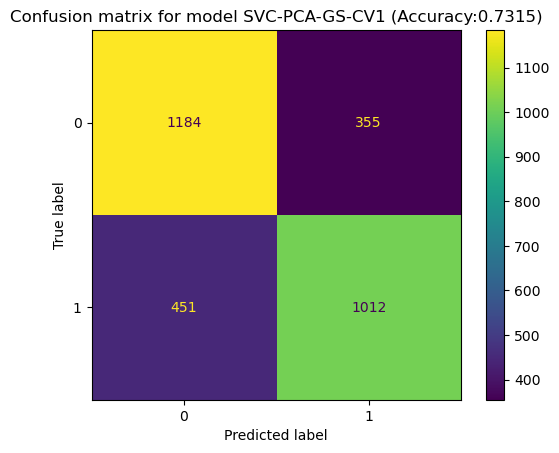

In [12]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('SVC-PCA-GS-CV1', y_test, predictions)

In [13]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = SVC(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7315123251165889
Parameters from place:  1   {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7275149900066622
Parameters from place:  2   {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7275149900066622
Parameters from place:  3   {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7255163224516988
Parameters from place:  4   {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy for chosen parameters: 0.7301798800799467
Parameters from place:  5   {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy for chosen parameters: 0.72618254497002
Parameters from place:  6   {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7268487674883412
Parameters from place:  7   {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy for chosen parameters: 0.7278481012658228
Parameters

In [14]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [15]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.7315123251165889
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Classification report of best model from alternatives of fine tuning

In [16]:
model = SVC(random_state=seed, **best_tuple[1])
model.fit(X_train, y_train)

predictions = model.predict(X_test)
current_accuracy = accuracy_score(y_test, predictions)

classification_report(y_test, predictions, zero_division=0)


'              precision    recall  f1-score   support\n\n           0       0.72      0.77      0.75      1539\n           1       0.74      0.69      0.72      1463\n\n    accuracy                           0.73      3002\n   macro avg       0.73      0.73      0.73      3002\nweighted avg       0.73      0.73      0.73      3002\n'

Metrics for SVC-PCA-alternatives:
Accuracy: 0.7315
Weighted F1: 0.7310
Weighted Precision: 0.7320
Weighted Recall: 0.7315
Macro-Averaged Precision: 0.7322
Macro-Averaged Recall: 0.7305
F1: [0.74606175 0.71519435]
Precision: [0.72415902 0.74030724]
classification report
              precision    recall  f1-score   support

     Class 0       0.72      0.77      0.75      1539
     Class 1       0.74      0.69      0.72      1463

    accuracy                           0.73      3002
   macro avg       0.73      0.73      0.73      3002
weighted avg       0.73      0.73      0.73      3002

Confusion Matrix


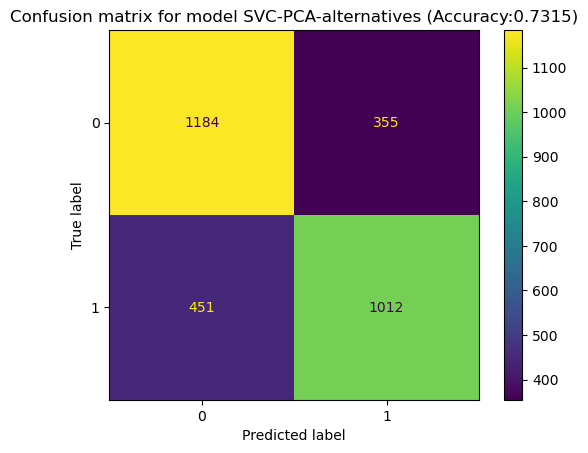

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
SVC-PCA-alternatives,0.731512,0.731019,0.732029,0.731512,0.732233,0.73053,[0.74606175 0.71519435],[0.72415902 0.74030724]


In [17]:
calculate_metrics('SVC-PCA-alternatives', y_test, predictions)